In [3]:
import matplotlib.pyplot as plt
import torch
from torch import nn

# LZ77 Algorithm

In [1]:
# https://github.com/manassra/LZ77-Compressor

import math
from bitarray import bitarray


class LZ77Compressor:
    """
    A simplified implementation of the LZ77 Compression Algorithm
    """
    MAX_WINDOW_SIZE = 400

    def __init__(self, window_size=20):
        self.window_size = min(window_size, self.MAX_WINDOW_SIZE)
        self.lookahead_buffer_size = 15  # length of match is at most 4 bits

    def compress(self, input_file_path, output_file_path=None, verbose=False):
        """
        Given the path of an input file, its content is compressed by applying a simple
        LZ77 compression algorithm.

        The compressed format is:
        0 bit followed by 8 bits (1 byte character) when there are no previous matches
            within window
        1 bit followed by 12 bits pointer (distance to the start of the match from the
            current position) and 4 bits (length of the match)

        If a path to the output file is provided, the compressed data is written into
        a binary file. Otherwise, it is returned as a bitarray

        if verbose is enabled, the compression description is printed to standard output
        """
        data = None
        i = 0
        output_buffer = bitarray(endian='big')

        # read the input file
        try:
            with open(input_file_path, 'rb') as input_file:
                data = input_file.read()
        except IOError:
            print('Could not open input file ...')
            raise

        while i < len(data):
            # print(i)

            match = self.findLongestMatch(data, i)

            if match:
                # Add 1 bit flag, followed by 12 bit for distance, and 4 bit for the length
                # of the match
                (bestMatchDistance, bestMatchLength) = match

                output_buffer.append(True)
                output_buffer.frombytes(bytes([bestMatchDistance >> 4]))
                output_buffer.frombytes(bytes([((bestMatchDistance & 0xf) << 4) | bestMatchLength]))

                if verbose:
                    print("<1, %i, %i>" % (bestMatchDistance, bestMatchLength), end='')

                i += bestMatchLength

            else:
                # No useful match was found. Add 0 bit flag, followed by 8 bit for the character
                output_buffer.append(False)
                output_buffer.frombytes(bytes([data[i]]))

                if verbose:
                    print("<0, %s>" % data[i], end='')

                i += 1

        # fill the buffer with zeros if the number of bits is not a multiple of 8
        output_buffer.fill()

        # write the compressed data into a binary file if a path is provided
        if output_file_path:
            try:
                with open(output_file_path, 'wb') as output_file:
                    output_file.write(output_buffer.tobytes())
                    print("File was compressed successfully and saved to output path ...")
                    return None
            except IOError:
                print('Could not write to output file path. Please check if the path is correct ...')
                raise

        # an output file path was not provided, return the compressed data
        return output_buffer

    def findLongestMatch(self, data, current_position):
        """
        Finds the longest match to a substring starting at the current_position
        in the lookahead buffer from the history window
        """
        end_of_buffer = min(current_position + self.lookahead_buffer_size, len(data) + 1)

        best_match_distance = -1
        best_match_length = -1

        # Optimization: Only consider substrings of length 2 and greater, and just
        # output any substring of length 1 (8 bits uncompressed is better than 13 bits
        # for the flag, distance, and length)
        for j in range(current_position + 2, end_of_buffer):

            start_index = max(0, current_position - self.window_size)
            substring = data[current_position:j]

            for i in range(start_index, current_position):

                repetitions = len(substring) // (current_position - i)

                last = len(substring) % (current_position - i)

                matched_string = data[i:current_position] * repetitions + data[i:i + last]

                if matched_string == substring and len(substring) > best_match_length:
                    best_match_distance = current_position - i
                    best_match_length = len(substring)

        if best_match_distance > 0 and best_match_length > 0:
            return (best_match_distance, best_match_length)
        return None

    def compress_in_place(self, data, verbose=False):
        """
        Given the path of an input file, its content is compressed by applying a simple
        LZ77 compression algorithm.

        The compressed format is:
        0 bit followed by 8 bits (1 byte character) when there are no previous matches
            within window
        1 bit followed by 12 bits pointer (distance to the start of the match from the
            current position) and 4 bits (length of the match)

        If a path to the output file is provided, the compressed data is written into
        a binary file. Otherwise, it is returned as a bitarray

        if verbose is enabled, the compression description is printed to standard output
        """
        i = 0
        output_buffer = bitarray(endian='big')

        while i < len(data):

            # print(i)

            match = self.findLongestMatch(data, i)

            if match:
                # Add 1 bit flag, followed by 12 bit for distance, and 4 bit for the length
                # of the match
                (bestMatchDistance, bestMatchLength) = match

                output_buffer.append(True)
                output_buffer.frombytes(bytes([bestMatchDistance >> 4]))
                output_buffer.frombytes(bytes([((bestMatchDistance & 0xf) << 4) | bestMatchLength]))

                if verbose:
                    print("<1, %i, %i>" % (bestMatchDistance, bestMatchLength), end='')

                i += bestMatchLength

            else:
                # No useful match was found. Add 0 bit flag, followed by 8 bit for the character
                output_buffer.append(False)
                output_buffer.frombytes(bytes([data[i]]))

                if verbose:
                    print("<0, %s>" % data[i], end='')

                i += 1

        # fill the buffer with zeros if the number of bits is not a multiple of 8
        output_buffer.fill()

        # an output file path was not provided, return the compressed data
        return output_buffer

# functions for treat data

In [91]:
def bytes2torch(bytes):
    if not type(bytes) is list:
        data_integers = list(bytes)

    data_tensor = torch.tensor(data_integers, dtype=torch.uint8)

    return data_tensor


def tokenizer(byte_tensor, length, device):
    """"
    :param byte_tensor: torch tensor uint8
    :param length: length of the output, complete with padding if shorter
    :return: torch tensor int16
    """
    new_tensor = (byte_tensor[:length] + 1)
    zero_tensor = torch.zeros(length, dtype=torch.int64).to(device)
    zero_tensor[:new_tensor.size(0)] = new_tensor

    return zero_tensor


def tokenizer_for_transformer(byte_tensor, length, device, start_token=None, end_token=None):
    new_tensor = (byte_tensor[:length] + 1)

    if start_token and end_token:
        new_tensor = torch.cat([torch.tensor([start_token]), new_tensor, torch.tensor([end_token])])
    elif start_token:
        new_tensor = torch.cat([torch.tensor([start_token]), new_tensor])
    elif end_token:
        new_tensor = torch.cat([new_tensor, torch.tensor([end_token])])

    zero_tensor = torch.zeros(length, dtype=torch.int64).to(device)
    zero_tensor[:new_tensor.size(0)] = new_tensor

    return zero_tensor



## DataSet with files

In [17]:
# def data_for_transformer(batch):
#     # remove zeros
#     non_zero_mask = batch != 0
#     batch_without_zeros = torch.masked_select(batch, non_zero_mask)
#     
#     return batch_without_zeros
#     

In [92]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from generate_data import NB_MAX_TOKEN

START_TOKEN_TRANSFORMER = NB_MAX_TOKEN
END_TOKEN_TRANSFORMER = NB_MAX_TOKEN + 1


# [!] arg changed
class LZ77Dataset(Dataset):
    def __init__(self, length, device, features_folder="./data_LZ77/text", targets_folder="./data_LZ77/compress",
                 for_transformer=False, start_token=None, end_token=None):
        self.features_folder = features_folder
        self.targets_folder = targets_folder
        self.for_transformer = for_transformer
        self.length = length
        self.device = device
        self.start_token = start_token
        self.end_token = end_token

        # Listes des noms de fichiers dans les dossiers
        self.feature_files = os.listdir(features_folder)
        self.target_files = os.listdir(targets_folder)

    def __len__(self):
        return min(len(self.feature_files), len(self.target_files))

    def __getitem__(self, idx):
        feature_path = os.path.join(self.features_folder, self.feature_files[idx])
        target_path = os.path.join(self.targets_folder, self.target_files[idx])

        with open(feature_path, 'rb') as feature_file:
            feature_data = feature_file.read()
        with open(target_path, 'rb') as target_file:
            target_data = target_file.read()

        if self.for_transformer:
            encoder_input = tokenizer_for_transformer(bytes2torch(feature_data), self.length, self.device,
                                                      start_token=START_TOKEN_TRANSFORMER,
                                                      end_token=END_TOKEN_TRANSFORMER)
            decoder_input = tokenizer_for_transformer(bytes2torch(target_data), self.length, self.device,
                                                      start_token=START_TOKEN_TRANSFORMER, end_token=None)
            feature_data = (encoder_input, decoder_input)
            target_data = tokenizer_for_transformer(bytes2torch(target_data), self.length, self.device,
                                                    start_token=None, end_token=END_TOKEN_TRANSFORMER)

        else:
            feature_data = tokenizer(bytes2torch(feature_data), self.length, self.device)
            target_data = tokenizer(bytes2torch(target_data), self.length, self.device)

        return feature_data, target_data

# set train and test loader

In [348]:
# [!] padding avec zero a bien faire attention que identique
# [!] verifier que les to(device) sont dans les init ou a la creation

from torch.utils.data import random_split
from generate_data import SENTENCE_LENGTH

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NB_SPECIAL_TOKEN = 2
NB_MAX_TOKEN_TRANSFORMER = NB_MAX_TOKEN + NB_SPECIAL_TOKEN
MAX_LENGTH = SENTENCE_LENGTH + NB_SPECIAL_TOKEN + 5  # [!] need to change for +5
length_sentence = SENTENCE_LENGTH
repetition_probability = 0.5
size_data_set = 1000
batch_size = 64
test_proportion = 0.2

lz77_dataset = LZ77Dataset(MAX_LENGTH, device, for_transformer=True)

test_size = int(test_proportion * len(lz77_dataset))

train_dataset, test_dataset = random_split(lz77_dataset, [len(lz77_dataset) - test_size, test_size])

lz77_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
lz77_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

for batch in lz77_train_loader:
    (txt_example, cmp_input_example), cmp_output_example = batch
    break

print("feature and target :", (txt_example[0], cmp_input_example[0]), cmp_output_example[0])

feature and target : (tensor([257, 117, 117, 117, 117, 117, 117, 117,  77, 117,  77, 117, 117, 117,
         77,  78,  78, 117,  44,  67, 117, 106, 117,  67,  36, 117,  92, 117,
         36,  70,  77,  52,  92, 117,  60, 117, 117,  67,  78,  77, 117, 258,
          0,   0,   0,   0,   0], device='cuda:0'), tensor([257,  59,  65,   6, 138, 145,   3,  57,   4,  26,  53, 155, 117,  22,
        145, 143, 135, 148, 162,   9,  71, 117,  46, 158,   5, 101,  83,  97,
        207,   1, 197,  60,  59,  65,  57, 138, 165, 196, 161,   0,   0,   0,
          0,   0,   0,   0,   0], device='cuda:0')) tensor([ 59,  65,   6, 138, 145,   3,  57,   4,  26,  53, 155, 117,  22, 145,
        143, 135, 148, 162,   9,  71, 117,  46, 158,   5, 101,  83,  97, 207,
          1, 197,  60,  59,  65,  57, 138, 165, 196, 161, 258,   0,   0,   0,
          0,   0,   0,   0,   0], device='cuda:0')


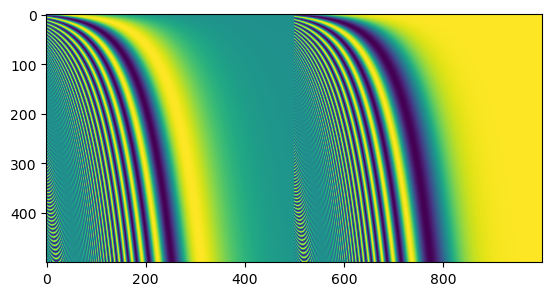

In [349]:
def positional_encoding(length, depth, device):
    depth = depth // 2

    positions = torch.arange(length).unsqueeze(1).float().to(device)  # (seq, 1)
    depths = (torch.arange(depth).unsqueeze(0).float() / depth).to(device)  # (1, depth)

    angle_rates = 1 / (10000 ** depths)  # (1, depth)
    angle_rads = positions * angle_rates  # (pos, depth)

    pos_encoding = torch.cat(
        [torch.sin(angle_rads), torch.cos(angle_rads)],
        dim=-1
    )

    return pos_encoding.float()


# Example usage:
import matplotlib.pyplot as plt

length = 500
depth = 1000
pos_encoding = positional_encoding(length, depth, device)
plt.imshow(pos_encoding.to('cpu'))

In [350]:
PADDING_VALUE = 0


# [!] il faudra prendre en compte les mask

class PositionalEmbedding(nn.Module):
    def __init__(self, vocab_size, d_model, device):
        super().__init__()
        self.device = device
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=PADDING_VALUE).to(self.device)
        self.pos_encoding = positional_encoding(length=MAX_LENGTH, depth=d_model, device=self.device)

    def forward(self, x):
        length = x.size(1)

        x = self.embedding(x)  # (batch,length_x = max_length,d_model)

        x *= torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32)).to(self.device)  # Apply scaling
        x = x + self.pos_encoding[:length, :]  # Add position encodings
        return x




In [154]:
embed_txt = PositionalEmbedding(vocab_size=NB_MAX_TOKEN_TRANSFORMER, d_model=512, device=device)
embed_cmp = PositionalEmbedding(vocab_size=NB_MAX_TOKEN_TRANSFORMER, d_model=512, device=device)

txt_example_embed = embed_txt(txt_example)
print()
cmp_input_example_embed = embed_cmp(cmp_input_example)

print("txt_example_embed", txt_example_embed.shape)
print("cmp_input_example_embed", cmp_input_example_embed.shape)
print("cmp_input_example_embed mask", cmp_input_example_embed != 0)


txt_example_embed torch.Size([5, 47, 512])
cmp_input_example_embed torch.Size([5, 47, 512])
cmp_input_example_embed mask tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., Tru

## ATTENTION LAYERS

In [351]:
class BaseAttention(nn.Module):
    def __init__(self, device, embed_dim, num_heads, kdim, **kwargs):
        super(BaseAttention, self).__init__()
        self.device = device
        self.mha = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, kdim=kdim, dropout=0.1,  **kwargs).to(
            self.device)
        self.layernorm = nn.LayerNorm(embed_dim).to(device)
        self.last_attn_scores = None

In [352]:
class CrossAttention(BaseAttention):
    def forward(self, x, context):
        attn_output, attn_scores = self.mha(
            query=x,
            key=context,
            value=context
        )

        # Cache the attention scores for later use (if needed).
        self.last_attn_scores = attn_scores

        x = x + attn_output
        x = self.layernorm(x)

        return x

In [353]:
sample_ca = CrossAttention(device=device, num_heads=2, kdim=512, embed_dim=512)

print(txt_example_embed.shape)
print(cmp_input_example_embed.shape)
print(sample_ca(txt_example_embed, cmp_input_example_embed).shape)

torch.Size([5, 47, 512])
torch.Size([5, 47, 512])
torch.Size([5, 47, 512])


In [354]:
class GlobalSelfAttention(BaseAttention):
    def forward(self, x):
        attn_output, _ = self.mha(
            query=x,
            value=x,
            key=x)
        x = x + attn_output
        x = self.layernorm(x)

        return x

In [580]:
sample_gsa = GlobalSelfAttention(device=device, num_heads=2, kdim=512, embed_dim=512)

print(txt_example_embed.shape)
print(sample_gsa(txt_example_embed).shape)

torch.Size([5, 47, 512])
torch.Size([5, 47, 512])


In [665]:
def generate_causal_mask(size):
    return nn.Transformer.generate_square_subsequent_mask(size)


class CausalSelfAttention(BaseAttention):

    def forward(self, x):
        causal_mask = torch.triu(torch.ones(x.size(0), x.size(0)), diagonal=1).bool().to(x.device).flip(
            dims=[])  # [!] verify good mask

        # print(causal_mask)
        # plt.imshow(causal_mask.to('cpu'))

        attn_output, _ = self.mha(
            query=x,
            value=x,
            key=x,
            is_causal = True,
            attn_mask=causal_mask)

        x = attn_output
        x = x + self.layernorm(x)
        return x



In [666]:
sample_csa = CausalSelfAttention(device=device, num_heads=2, kdim=512, embed_dim=512)

print(txt_example_embed.shape)
print(sample_csa(txt_example_embed).shape)

torch.Size([5, 47, 512])
torch.Size([5, 47, 512])


In [667]:
# verification of causality

sample_csa.eval()

print(txt_example.shape)

out1 = sample_csa(embed_txt(txt_example[:, :3])) 
out2 = sample_csa(embed_txt(txt_example))[:, :3]

# print(torch.abs(out1 - out2))

print("res", torch.max(torch.abs(out1 - out2)).item())
# [!] pas bon !
sample_csa.train()


torch.Size([64, 47])
res 0.0030517578125


CausalSelfAttention(
  (mha): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
  )
  (layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
)

## feed forward network

In [643]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FeedForward(nn.Module):
    def __init__(self, d_model, dff, device, dropout_rate=0.1):
        super(FeedForward, self).__init__()
        self.device = device

        self.seq = nn.Sequential(
            nn.Linear(d_model, dff),
            nn.ReLU(),
            nn.Linear(dff, d_model),
            nn.Dropout(dropout_rate)
        ).to(self.device)

        self.layer_norm = nn.LayerNorm(d_model).to(self.device)

    def forward(self, x):
        x = x + self.seq(x)
        x = self.layer_norm(x)
        return x


In [644]:
sample_ffn = FeedForward(512, 2048, device)

print(cmp_input_example_embed.shape)
print(sample_ffn(cmp_input_example_embed).shape)

torch.Size([5, 47, 512])
torch.Size([5, 47, 512])


## Encode layer

In [647]:
class EncoderLayer(nn.Module):
    def __init__(self, device, d_model, num_heads, dff, dropout_rate=0.1):
        super(EncoderLayer, self).__init__()
        self.device = device

        self.self_attention = GlobalSelfAttention(
            device=self.device,
            num_heads=num_heads,
            embed_dim=d_model,
            kdim=d_model,
        )

        self.ffn = FeedForward( d_model, dff, device, dropout_rate)

    def forward(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

In [648]:
sample_encoder_layer = EncoderLayer(device=device, d_model=512, num_heads=8, dff=2048)

print(cmp_input_example_embed.shape)
print(sample_encoder_layer(cmp_input_example_embed).shape)

torch.Size([5, 47, 512])
torch.Size([5, 47, 512])
